# Initial model building and testing (XGBoost, etc.)

In [1]:
import json
import pandas as pd
import numpy as np

import os
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
import sklearn.model_selection
import sklearn.metrics
import sklearn.ensemble

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

## Prepare Data for Modeling

In [3]:
# Load the processed data
data = pd.read_csv('../data/train_processed.csv')

# Separate features (X) and target (y)
# Drop the target column from features
X = data.drop(['went_on_backorder', 'sku'], axis=1)
y = data['went_on_backorder']

# Split the data into training and validation sets
# Using stratify to maintain class distribution due to imbalance
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.2,  # 20% for validation
    random_state=42,  # for reproducibility
    stratify=y  # maintain class distribution
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("\nClass distribution:")
print("Training set:", pd.Series(y_train).value_counts(normalize=True))
print("Validation set:", pd.Series(y_val).value_counts(normalize=True))

Training set shape: (1350288, 29)
Validation set shape: (337572, 29)

Class distribution:
Training set: went_on_backorder
0    0.99331
1    0.00669
Name: proportion, dtype: float64
Validation set: went_on_backorder
0    0.993308
1    0.006692
Name: proportion, dtype: float64


## Build, Train, and Evaluate Models

### Basic Model with Logistic Regression

In [4]:
# Define evaluation metrics function
def evaluate_model(y_true, y_pred, y_pred_proba=None):
    print("Classification Report:")
    print(sklearn.metrics.classification_report(y_true, y_pred))
    
    if y_pred_proba is not None:
        auc_roc = sklearn.metrics.roc_auc_score(y_true, y_pred_proba)
        auc_pr = sklearn.metrics.average_precision_score(y_true, y_pred_proba)
        print(f"\nROC AUC Score: {auc_roc:.4f}")
        print(f"PR AUC Score: {auc_pr:.4f}")


In [5]:
# 1. Logistic Regression with class weights
print("Training Logistic Regression...")
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)
lr_model.fit(X_train, y_train)


Training Logistic Regression...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [18]:

# Evaluate
y_pred_lr = lr_model.predict(X_val)
y_pred_proba_lr = lr_model.predict_proba(X_val)[:, 1]
print("\nLogistic Regression Results:")
evaluate_model(y_val, y_pred_lr, y_pred_proba_lr)


Logistic Regression Results:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    335313
           1       0.04      0.87      0.08      2259

    accuracy                           0.86    337572
   macro avg       0.52      0.87      0.50    337572
weighted avg       0.99      0.86      0.92    337572


ROC AUC Score: 0.9334
PR AUC Score: 0.1334


In [7]:
import pickle
with open('../models/lr_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

### XGBoost Classifier

In [8]:
# 2. XGBoost with scale_pos_weight
print("\nTraining XGBoost...")
# Calculate scale_pos_weight
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='aucpr',
    early_stopping_rounds=10,
    n_jobs=-1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)




Training XGBoost...


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,10
,enable_categorical,False
,eval_metric,'aucpr'


In [9]:
# Evaluate
y_pred_xgb = xgb_model.predict(X_val)
y_pred_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]
print("\nXGBoost Results:")
evaluate_model(y_val, y_pred_xgb, y_pred_proba_xgb)


XGBoost Results:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94    335313
           1       0.05      0.88      0.09      2259

    accuracy                           0.88    337572
   macro avg       0.52      0.88      0.51    337572
weighted avg       0.99      0.88      0.93    337572


ROC AUC Score: 0.9536
PR AUC Score: 0.1994


In [10]:
with open('../models/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

### LightGBM Classifier

In [11]:
# 3. LightGBM with built-in class weights
print("\nTraining LightGBM...")
lgb_model = lgb.LGBMClassifier(
    class_weight='balanced',
    learning_rate=0.1,
    n_estimators=100,
    num_leaves=31,
    early_stopping_rounds=10,
    n_jobs=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)]
)


Training LightGBM...
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9034, number of negative: 1341254
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 1350288, number of used features: 29
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9034, number of negative: 1341254
[LightGBM] [Info] Auto-choosing row-wise multi-thre

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [12]:

# Evaluate
y_pred_lgb = lgb_model.predict(X_val)
y_pred_proba_lgb = lgb_model.predict_proba(X_val)[:, 1]
print("\nLightGBM Results:")
evaluate_model(y_val, y_pred_lgb, y_pred_proba_lgb)



LightGBM Results:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    335313
           1       0.05      0.89      0.10      2259

    accuracy                           0.89    337572
   macro avg       0.52      0.89      0.52    337572
weighted avg       0.99      0.89      0.93    337572


ROC AUC Score: 0.9571
PR AUC Score: 0.1956


In [13]:
with open('../models/lgb_model.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

### Random Forest

In [14]:
rf_model = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    n_jobs=-1
)

rf_model.fit(
    X_train, y_train
)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
# Eval
y_pred_rf = rf_model.predict(X_val)
y_pred_proba_rf = rf_model.predict_proba(X_val)[:, 1]
print("\nRandom Forest Results:")
evaluate_model(y_val, y_pred_rf, y_pred_proba_rf)


Random Forest Results:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    335313
           1       0.21      0.30      0.25      2259

    accuracy                           0.99    337572
   macro avg       0.60      0.65      0.62    337572
weighted avg       0.99      0.99      0.99    337572


ROC AUC Score: 0.9457
PR AUC Score: 0.1662


In [16]:
with open('../models/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

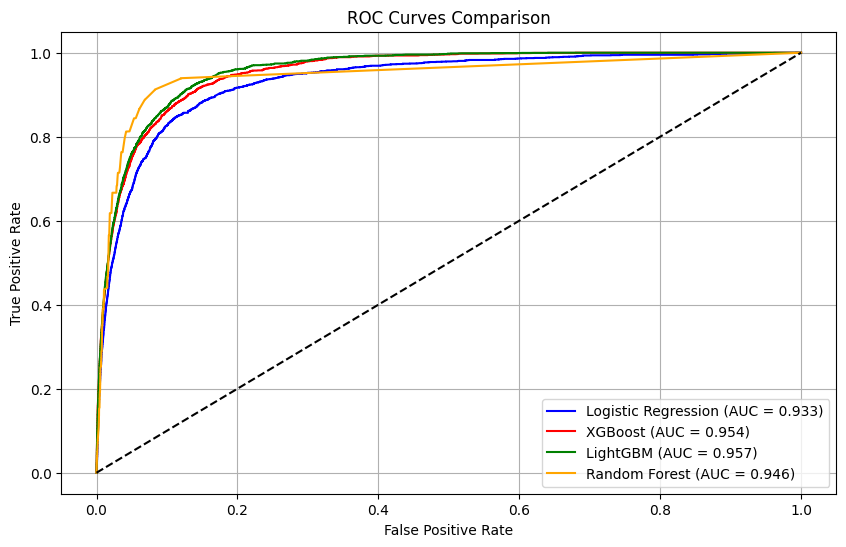

In [19]:

# Compare models using ROC curves
plt.figure(figsize=(10, 6))
models = {
    'Logistic Regression': (y_pred_proba_lr, 'blue'),
    'XGBoost': (y_pred_proba_xgb, 'red'),
    'LightGBM': (y_pred_proba_lgb, 'green'),
    'Random Forest': (y_pred_proba_rf, 'orange')
}

for model_name, (y_pred_proba, color) in models.items():
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_val, y_pred_proba)
    auc = sklearn.metrics.roc_auc_score(y_val, y_pred_proba)
    plt.plot(fpr, tpr, color=color, label=f'{model_name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()


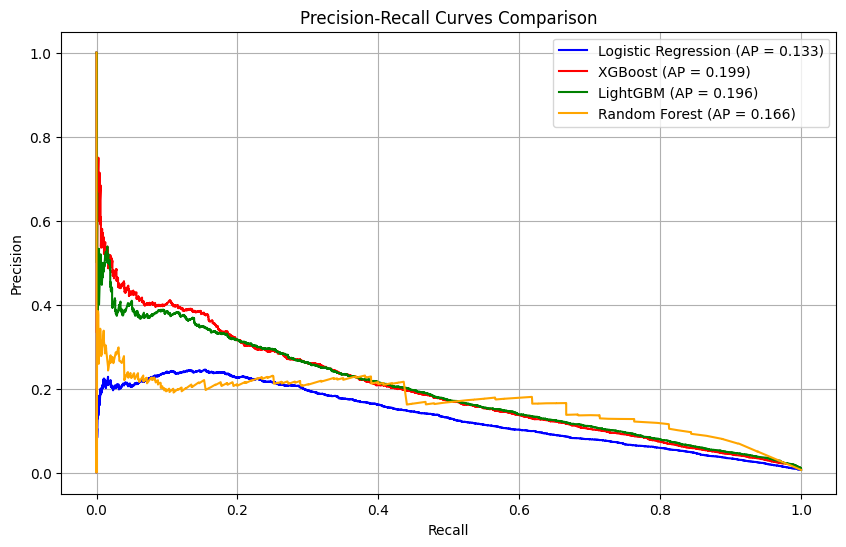

In [20]:

# Compare models using Precision-Recall curves
plt.figure(figsize=(10, 6))
for model_name, (y_pred_proba, color) in models.items():
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y_val, y_pred_proba)
    ap = sklearn.metrics.average_precision_score(y_val, y_pred_proba)
    plt.plot(recall, precision, color=color, label=f'{model_name} (AP = {ap:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Create a summary DataFrame comparing all models
model_names = ['Logistic Regression', 'XGBoost', 'LightGBM', 'Random Forest']
y_preds = [y_pred_lr, y_pred_xgb, y_pred_lgb, y_pred_rf]
y_pred_probas = [y_pred_proba_lr, y_pred_proba_xgb, y_pred_proba_lgb, y_pred_proba_rf]

summary_data = []
for name, y_pred, y_pred_proba in zip(model_names, y_preds, y_pred_probas):
    metrics = {
        'Model': name,
        'Accuracy': sklearn.metrics.accuracy_score(y_val, y_pred),
        'Precision': sklearn.metrics.precision_score(y_val, y_pred),
        'Recall': sklearn.metrics.recall_score(y_val, y_pred),
        'F1 Score': sklearn.metrics.f1_score(y_val, y_pred),
        'ROC AUC': sklearn.metrics.roc_auc_score(y_val, y_pred_proba),
        'PR AUC': sklearn.metrics.average_precision_score(y_val, y_pred_proba)
    }
    summary_data.append(metrics)

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.set_index('Model')

# Format all numeric columns to 4 decimal places
summary_df = summary_df.round(4)

# Display the summary table
print("Model Performance Summary:")
summary_df




Model Performance Summary:


,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
Model,,,,,,
Logistic Regression,0.8581,0.0397,0.8721,0.0760,0.9334,0.1334
XGBoost,0.8830,0.0484,0.8840,0.0918,0.9536,0.1994
LightGBM,0.8870,0.0505,0.8920,0.0956,0.9571,0.1956
Random Forest,0.9877,0.2098,0.3006,0.2471,0.9457,0.1662


In [24]:
# Identify the best model for each metric
best_models = summary_df.idxmax()
print("\nBest performing model for each metric:")
for metric, model in best_models.items():
    print(f"{metric}: {model} ({summary_df.loc[model, metric]:.4f})")


Best performing model for each metric:
Accuracy: Random Forest (0.9877)
Precision: Random Forest (0.2098)
Recall: LightGBM (0.8920)
F1 Score: Random Forest (0.2471)
ROC AUC: LightGBM (0.9571)
PR AUC: XGBoost (0.1994)


In [33]:
print(f"XGBoost version: {xgb.__version__}")
print("XGBoost build info:")
print(xgb.build_info())

XGBoost version: 3.1.1
XGBoost build info:
{'BUILTIN_PREFETCH_PRESENT': False, 'CUDA_VERSION': [12, 5], 'DEBUG': False, 'MM_PREFETCH_PRESENT': True, 'THRUST_VERSION': [2, 6, 1], 'USE_CUDA': True, 'USE_DLOPEN_NCCL': False, 'USE_FEDERATED': False, 'USE_NCCL': False, 'USE_NVCOMP': False, 'USE_OPENMP': True, 'USE_RMM': False, 'libxgboost': 'd:\\Coding\\DLDFE\\venv\\lib\\site-packages\\xgboost\\lib\\xgboost.dll'}


## Hyperparameter Tuning

Based on our initial results, we'll focus on tuning LightGBM and XGBoost as they showed the best performance on key metrics for imbalanced classification:

1. LightGBM showed best:
   - Recall (0.8920) - Important for identifying actual backorder cases
   - ROC AUC (0.9571) - Good overall discrimination

2. XGBoost showed best:
   - PR AUC (0.1994) - Important for imbalanced datasets
   
We'll use GridSearchCV with stratified k-fold cross-validation to maintain class distribution.

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer, average_precision_score, recall_score
# Define scoring metrics
scoring = {
    'PR_AUC': make_scorer(average_precision_score),
    'Recall': make_scorer(recall_score),
    'ROC_AUC': 'roc_auc'
}

# LightGBM parameter distribution
lgb_param_dist = {
    'learning_rate': uniform(0.01, 0.19),  # uniform between 0.01 and 0.2
    'n_estimators': randint(50, 300),
    'num_leaves': randint(20, 100),
    'min_child_samples': randint(10, 100),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),  # uniform between 0.6 and 1.0
    'colsample_bytree': uniform(0.6, 0.4)
}


In [28]:

# Create and run RandomizedSearchCV for LightGBM with GPU
lgb_random = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(
        class_weight='balanced',
        n_jobs=-1,
        device='gpu',  # Use GPU
        gpu_platform_id=0,
        gpu_device_id=0
    ),
    param_distributions=lgb_param_dist,
    n_iter=20,  # number of parameter settings that are sampled
    scoring=scoring,
    refit='PR_AUC',
    cv=3,  # reduced from 5 to 3 for faster training
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Starting LightGBM Random Search...")
lgb_random.fit(X_train, y_train)


Starting LightGBM Random Search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9034, number of negative: 1341254
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 1350288, number of used features: 29
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9034, number of negative: 1341254
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 1350288, number of used features: 29
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenC

,estimator,"LGBMClassifie...=0, n_jobs=-1)"
,param_distributions,"{'colsample_bytree': <scipy.stats....0015A49AD3520>, 'learning_rate': <scipy.stats....0015A3EFC2BC0>, 'max_depth': <scipy.stats....0015A49AD3460>, 'min_child_samples': <scipy.stats....0015A49AD2FB0>, ...}"
,n_iter,20
,scoring,"{'PR_AUC': make_scorer(a...hod='predict'), 'ROC_AUC': 'roc_auc', 'Recall': make_scorer(r...hod='predict')}"
,n_jobs,-1
,refit,'PR_AUC'
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [29]:

print("\nLightGBM Best Parameters:", lgb_random.best_params_)
print("Best PR-AUC Score:", lgb_random.best_score_)



LightGBM Best Parameters: {'colsample_bytree': np.float64(0.8391599915244341), 'learning_rate': np.float64(0.1851561046543922), 'max_depth': 8, 'min_child_samples': 96, 'n_estimators': 298, 'num_leaves': 81, 'subsample': np.float64(0.7301321323053057)}
Best PR-AUC Score: 0.08101506828955167


In [30]:

# XGBoost parameter distribution
xgb_param_dist = {
    'learning_rate': uniform(0.01, 0.19),
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 7),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 1)
}


In [34]:
# Create and run RandomizedSearchCV for XGBoost with GPU
xgb_random = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        tree_method='hist',  # Changed from gpu_hist to hist
        device='cuda',      # Added device parameter
        eval_metric='aucpr',
        n_jobs=-1
    ),
    param_distributions=xgb_param_dist,
    n_iter=20,  # number of parameter settings that are sampled
    scoring=scoring,
    refit='PR_AUC',
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("\nStarting XGBoost Random Search...")
xgb_random.fit(X_train, y_train)


Starting XGBoost Random Search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': <scipy.stats....0015A49AD3340>, 'gamma': <scipy.stats....0015A49AD2AD0>, 'learning_rate': <scipy.stats....00159DFFA83A0>, 'max_depth': <scipy.stats....0015A3EFC39D0>, ...}"
,n_iter,20
,scoring,"{'PR_AUC': make_scorer(a...hod='predict'), 'ROC_AUC': 'roc_auc', 'Recall': make_scorer(r...hod='predict')}"
,n_jobs,-1
,refit,'PR_AUC'
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [35]:

print("\nXGBoost Best Parameters:", xgb_random.best_params_)
print("Best PR-AUC Score:", xgb_random.best_score_)



XGBoost Best Parameters: {'colsample_bytree': np.float64(0.7799016533479063), 'gamma': np.float64(0.3951502360018144), 'learning_rate': np.float64(0.1860651845008209), 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 264, 'subsample': np.float64(0.8083337040103294)}
Best PR-AUC Score: 0.11565004044097811


In [36]:

# Train final models with best parameters
best_lgb = lgb.LGBMClassifier(
    **lgb_random.best_params_,
    class_weight='balanced',
    n_jobs=-1,
    device='gpu'
)


# Fit final models
best_lgb.fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9034, number of negative: 1341254
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 1350288, number of used features: 29
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (15.45 MB) transferred to GPU in 0.058301 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,boosting_type,'gbdt'
,num_leaves,81
,max_depth,8
,learning_rate,np.float64(0.1851561046543922)
,n_estimators,298
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,96


In [38]:
best_xgb = xgb.XGBClassifier(
    **xgb_random.best_params_,
    scale_pos_weight=scale_pos_weight,
    tree_method='hist',
    device='cuda'
)
best_xgb.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,np.float64(0.7799016533479063)
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [40]:

# Evaluate
y_pred_best_xgb = best_xgb.predict(X_val)
y_pred_proba_best_xgb = best_xgb.predict_proba(X_val)[:, 1]
print("\nBest XGBoost Results:")
evaluate_model(y_val, y_pred_best_xgb, y_pred_proba_best_xgb)


Best XGBoost Results:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    335313
           1       0.16      0.77      0.26      2259

    accuracy                           0.97    337572
   macro avg       0.58      0.87      0.62    337572
weighted avg       0.99      0.97      0.98    337572


ROC AUC Score: 0.9689
PR AUC Score: 0.4209


In [41]:

# Evaluate
y_pred_best_lgb = best_lgb.predict(X_val)
y_pred_proba_best_lgb = best_lgb.predict_proba(X_val)[:, 1]
print("\n Best lgb Results:")
evaluate_model(y_val, y_pred_best_lgb, y_pred_proba_best_lgb)


 Best lgb Results:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    335313
           1       0.09      0.84      0.17      2259

    accuracy                           0.94    337572
   macro avg       0.55      0.89      0.57    337572
weighted avg       0.99      0.94      0.97    337572


ROC AUC Score: 0.9648
PR AUC Score: 0.3227


Based on the results, XGBoost appears to be the best model as it shows better performance across all metrics:

- Higher precision (0.16 vs 0.09) for class 1 (backorders)
- Better PR AUC Score (0.4209 vs 0.3227)
- Better ROC AUC Score (0.9689 vs 0.9648)
- Better F1-score (0.26 vs 0.17) for backorders

In [42]:
# Save best models
with open('../models/best_lgb_model.pkl', 'wb') as f:
    pickle.dump(best_lgb, f)
with open('../models/best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

## Final Evaluation and Model Analysis

1. Feature Importance Analysis
2. Final Model Evaluation on Test Set
3. Threshold Optimization
4. Business Impact Analysis

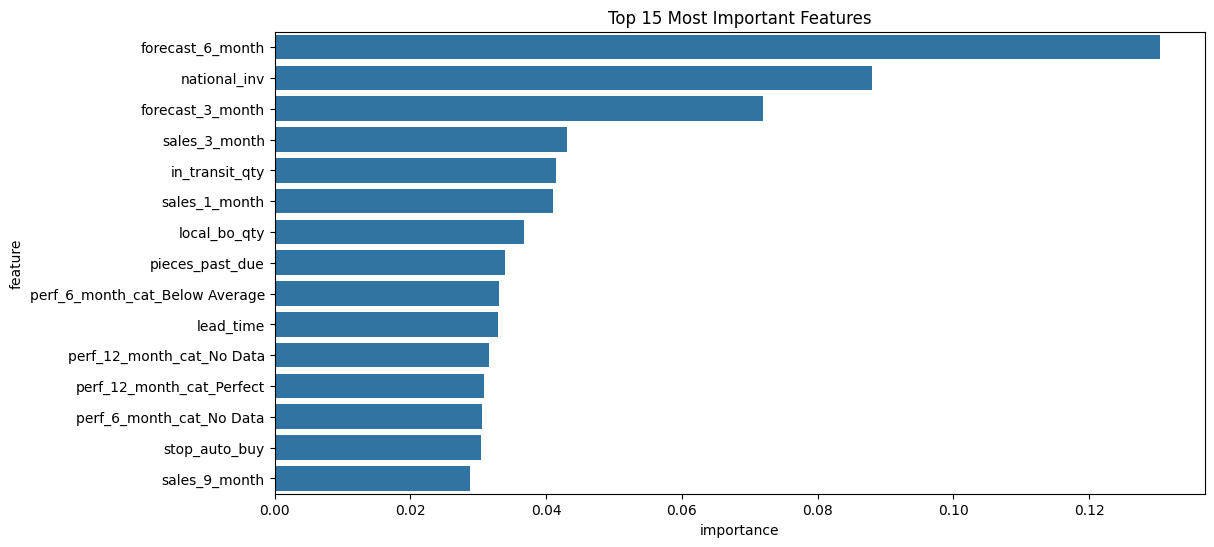

Top 15 Most Important Features:
                           feature  importance
4                 forecast_6_month    0.130466
0                     national_inv    0.087939
3                 forecast_3_month    0.071905
7                    sales_3_month    0.043036
2                   in_transit_qty    0.041397
6                    sales_1_month    0.040946
13                    local_bo_qty    0.036790
12                 pieces_past_due    0.033948
21  perf_6_month_cat_Below Average    0.033133
1                        lead_time    0.032874
27       perf_12_month_cat_No Data    0.031571
28       perf_12_month_cat_Perfect    0.030876
22        perf_6_month_cat_No Data    0.030573
17                   stop_auto_buy    0.030365
9                    sales_9_month    0.028837


In [49]:
# 1. Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.show()

# Print feature importance
print("Top 15 Most Important Features:")
print(feature_importance.head(15))



In [50]:
# 2. Load and prepare test data
test_data = pd.read_csv('../data/test_processed.csv')
X_test = test_data.drop(['went_on_backorder', 'sku'], axis=1)
y_test = test_data['went_on_backorder']


In [51]:

# 3. Predict on test set
y_pred_test = best_xgb.predict(X_test)
y_pred_proba_test = best_xgb.predict_proba(X_test)[:, 1]


In [52]:

# 4. Calculate metrics
print("\nFinal Test Set Evaluation:")
evaluate_model(y_test, y_pred_test, y_pred_proba_test)



Final Test Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    239387
           1       0.16      0.41      0.23      2688

    accuracy                           0.97    242075
   macro avg       0.58      0.69      0.61    242075
weighted avg       0.98      0.97      0.98    242075


ROC AUC Score: 0.8969
PR AUC Score: 0.1586


In [53]:

# 5. Threshold Optimization
thresholds = np.arange(0.1, 0.9, 0.1)
results = []

for threshold in thresholds:
    y_pred_custom = (y_pred_proba_test > threshold).astype(int)
    precision = sklearn.metrics.precision_score(y_test, y_pred_custom)
    recall = sklearn.metrics.recall_score(y_test, y_pred_custom)
    f1 = sklearn.metrics.f1_score(y_test, y_pred_custom)
    results.append({'threshold': threshold, 'precision': precision, 
                   'recall': recall, 'f1': f1})

threshold_df = pd.DataFrame(results)
print("\nThreshold Analysis:")
print(threshold_df)



Threshold Analysis:
   threshold  precision    recall        f1
0        0.1   0.080048  0.640625  0.142314
1        0.2   0.105921  0.558408  0.178065
2        0.3   0.119033  0.503720  0.192562
3        0.4   0.144977  0.454241  0.219802
4        0.5   0.159395  0.411830  0.229835
5        0.6   0.172536  0.360863  0.233454
6        0.7   0.188170  0.313616  0.235212
7        0.8   0.217978  0.252604  0.234017


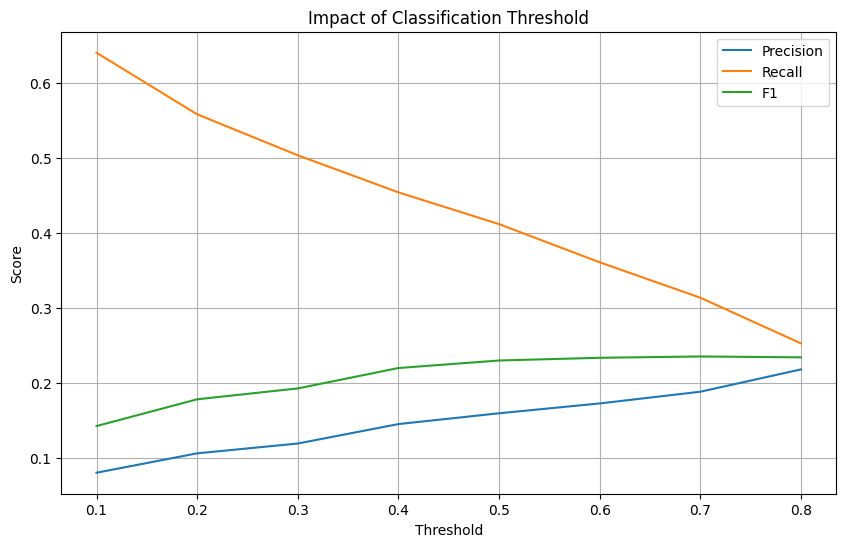

In [54]:

# Plot threshold impact
plt.figure(figsize=(10, 6))
plt.plot(threshold_df['threshold'], threshold_df['precision'], label='Precision')
plt.plot(threshold_df['threshold'], threshold_df['recall'], label='Recall')
plt.plot(threshold_df['threshold'], threshold_df['f1'], label='F1')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Impact of Classification Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [55]:

# 6. Business Impact Analysis (example with default 0.5 threshold)
total_items = len(y_test)
predicted_backorders = y_pred_test.sum()
actual_backorders = y_test.sum()
correct_backorder_predictions = ((y_pred_test == 1) & (y_test == 1)).sum()

print("\nBusiness Impact Analysis:")
print(f"Total items evaluated: {total_items}")
print(f"Predicted backorders: {predicted_backorders} ({predicted_backorders/total_items*100:.2f}%)")
print(f"Actual backorders: {actual_backorders} ({actual_backorders/total_items*100:.2f}%)")
print(f"Correctly predicted backorders: {correct_backorder_predictions} "
      f"({correct_backorder_predictions/actual_backorders*100:.2f}% of actual backorders)")



Business Impact Analysis:
Total items evaluated: 242075
Predicted backorders: 6945 (2.87%)
Actual backorders: 2688 (1.11%)
Correctly predicted backorders: 1107 (41.18% of actual backorders)


In [56]:

# Save final model predictions for later use
test_data['predicted_probability'] = y_pred_proba_test
test_data['predicted_backorder'] = y_pred_test
test_data.to_csv('../data/test_predictions.csv', index=False)

## Primary Finding

The model successfully identifies 41% of all actual backorders (Recall = 0.41) on the unseen test data. While this means some backorders are still missed, it provides supply chain planners with a powerful early warning system for a large portion of potential stockouts.

Threshold Optimization is Crucial: The model's default 0.5 probability threshold yields the 41% recall. However, this can be adjusted to meet specific business needs:

For Higher Detection (Aggressive Strategy): Lowering the threshold to 0.1 increases the detection rate to 64% of all backorders, allowing planners to be more proactive at the cost of more false alarms (Precision drops to 8%).

For Higher Confidence (Conservative Strategy): Increasing the threshold to 0.8 improves the alert quality, with 22% of alerts being correct backorders, though this only captures 25% of total backorders.

Key Predictive Drivers: The most important features driving backorder predictions are:

6-Month Sales Forecast (forecast_6_month)

Current Inventory Level (national_inv)

3-Month Sales Forecast (forecast_3_month)